# Fit LDA ensemble

see: https://radimrehurek.com/gensim/auto_examples/tutorials/run_ensemblelda.html

In [1]:
import pickle
import pandas as pd
from gensim.models import LdaModel
from gensim.models import EnsembleLda
import numpy as np
import statistics
import os
from matplotlib import pyplot as plt 

%matplotlib inline

In [2]:
DATA_PATH = '../data'
MODELS_PATH = '../models'

## Load dictionary and corpus
Load the dictionary, tokenized train- and validate-corpus.

In [3]:
# Load the datasets for Computation and Language
with open(os.path.join(DATA_PATH, 'dictionary_cscl.pickle'), 'rb') as handle:
    dictionary_cscl = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_train_cscl.pickle'), 'rb') as handle:
    corpus_train_cscl = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_validate_cscl.pickle'), 'rb') as handle:
    corpus_validate_cscl = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_test_cscl.pickle'), 'rb') as handle:
    corpus_test_cscl = pickle.load(handle)

# Load the datasets for Gravitational Waves
with open(os.path.join(DATA_PATH, 'dictionary_gw.pickle'), 'rb') as handle:
    dictionary_gw = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_train_gw.pickle'), 'rb') as handle:
    corpus_train_gw = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_validate_gw.pickle'), 'rb') as handle:
    corpus_validate_gw = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'corpus_test_gw.pickle'), 'rb') as handle:
    corpus_test_gw = pickle.load(handle)

## Fit ensemble LDA

### Training

In [4]:
# parameters passed to the fit_ensemble_lda function
topic_model_class = LdaModel
ensemble_workers = 12
num_models = ensemble_workers * 2
distance_workers = 12
num_topics = 50
passes = 2

In [5]:
def fit_ensemble_lda(dictionary, corpus):
    """A function to train an ensemble LDA"""
    ensemble = EnsembleLda(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        num_models=num_models,
        topic_model_class=topic_model_class,
        ensemble_workers=ensemble_workers,
        distance_workers=distance_workers
    )
    return(ensemble)

### Optimize the epsilon parameter

Parameters for optimizing the $\epsilon$ clustering parameter

In [6]:
max_runs = 5  # the number of times the LDA ensemble will be trained
steps = 25  # the number of steps covering the epsilon range

In [7]:
def get_shape_range(ensemble, steps):
    """Get the range of epsilon values for this ensemble"""
    shape = ensemble.asymmetric_distance_matrix.shape
    without_diagonal = ensemble.asymmetric_distance_matrix[~np.eye(shape[0], dtype=bool)].reshape(shape[0], -1)
    return(np.linspace(without_diagonal.min(), without_diagonal.max(), num=steps))

In [8]:
def compute_perplexity_for_ensemble(dictionary, corpus_train, corpus_validate, max_runs, steps):
    """
    Trains LDA ensemble 'max_run' times, each time with with 'steps' different values of epsilon, return perplexity values.
    @return: a list of dataframes, one dataframe for each run. Each row in the dataframe has 'k' num stable topics, 'eps' clustering parameter epsilon, 'val' perplexity value.
    """
    perplexity = []
    for run in range(max_runs):
        print(f"Run {run + 1} / {max_runs}")
        eps = []
        num_topics_eps = []
        px = []
        ensemble = fit_ensemble_lda(dictionary, corpus_train)
        shape_range = get_shape_range(ensemble, steps)
        for val in shape_range:
            ensemble.recluster(eps=val)
            len_topics = len(ensemble.get_topics())
            num_topics_eps.append(len_topics)
            eps.append(val)
            if len_topics > 1:
                # compute the perplexity for this value of epsilon
                log_perplexity = ensemble.log_perplexity(corpus_validate)
                perplexity_eps = np.exp(-log_perplexity)
                px.append(perplexity_eps)
#                print(f"eps: {val} stable number of topics: {len_topics}, perplexity: {perplexity_eps}")
            else:
                # there's 1 or no stable topics, perplexity is infinite
                px.append(np.inf)
        perplexity.append(pd.DataFrame.from_dict({'k': num_topics_eps, 'eps': eps, 'val': px}))
    return(perplexity)


### Compute perplexity by value of $\epsilon$ clustering parameter for the gravitational waves dataset

In [9]:
%%time

perplexity_gw = compute_perplexity_for_ensemble(dictionary_gw, corpus_train_gw, corpus_validate_gw, max_runs, steps)

Run 1 / 5
Run 2 / 5
Run 3 / 5
Run 4 / 5
Run 5 / 5
CPU times: user 2min 12s, sys: 4.29 s, total: 2min 16s
Wall time: 10min 42s


### Compute perplexity by value of $\epsilon$ clustering parameter for the computation and language dataset

In [10]:
%%time

perplexity_cscl = compute_perplexity_for_ensemble(dictionary_cscl, corpus_train_cscl, corpus_validate_cscl, max_runs, steps)

Run 1 / 5
Run 2 / 5
Run 3 / 5
Run 4 / 5
Run 5 / 5
CPU times: user 6min 20s, sys: 5.11 s, total: 6min 25s
Wall time: 34min 32s


## Plot the perplexity curves

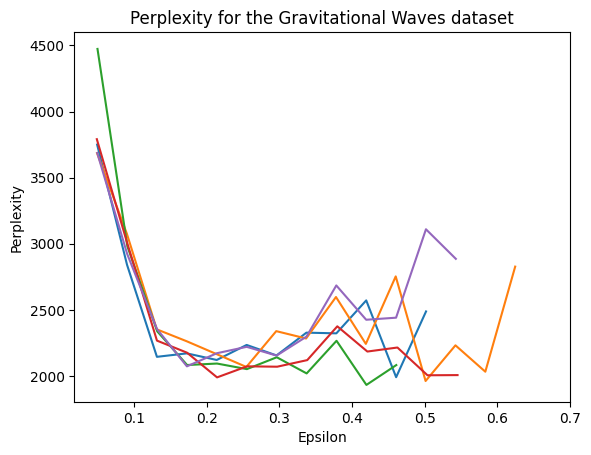

In [11]:
for run in range(max_runs):
    plt.plot(perplexity_gw[run].eps, perplexity_gw[run].val)
plt.title("Perplexity for the Gravitational Waves dataset")
plt.xlabel("Epsilon")
plt.ylabel("Perplexity")
plt.show()

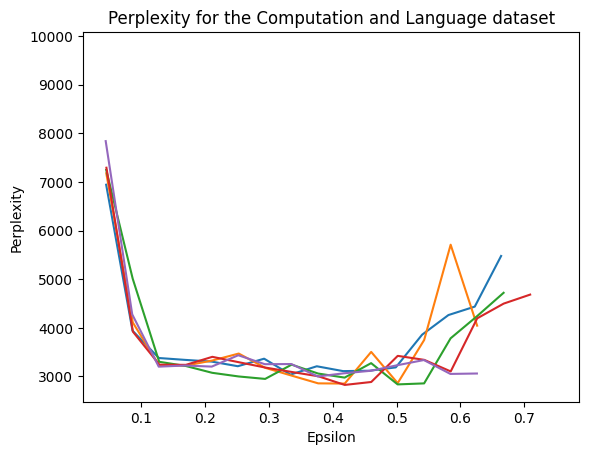

In [12]:
for run in range(max_runs):
    plt.plot(perplexity_cscl[run].eps, perplexity_cscl[run].val)
plt.title("Perplexity for the Computation and Language dataset")
plt.xlabel("Epsilon")
plt.ylabel("Perplexity")
plt.show()

### Find the best $\epsilon$ value: mode of list of best values for each run

In [13]:
def find_best_eps(max_runs, perplexity):
    best_eps_runs = []
    for run in range(max_runs):
        best_eps_runs.append(perplexity[run].sort_values('val', ascending=True).iloc[0]['eps'])
    best_eps = statistics.mode(best_eps_runs)
    return(best_eps)


In [14]:
best_eps_gw = find_best_eps(max_runs, perplexity_gw)
print(f"Best epsilon value for the Gravitational Waves dataset after {max_runs} runs is: {best_eps_gw}")

best_eps_cscl = find_best_eps(max_runs, perplexity_cscl)
print(f"Best epsilon value for the Computation and Language dataset after {max_runs} runs is: {best_eps_cscl}")

Best epsilon value for the Gravitational Waves dataset after 5 runs is: 0.46068864229378426
Best epsilon value for the Computation and Language dataset after 5 runs is: 0.33362130621333735


## Gravitation waves topics
Refit the model, with best $\epsilon$, on the test dataset

In [15]:
ensemble_gw = fit_ensemble_lda(dictionary_gw, corpus_test_gw)
ensemble_gw.recluster(eps=best_eps_gw, min_samples=2, min_cores=2)
print(f"Found {len(ensemble_gw.print_topics())} stable topics for the Gravitational Waves dataset")
ensemble_gw.print_topics(num_words=5)

Found 1 stable topics for the Gravitational Waves dataset


[(0,
  '0.010*"model" + 0.007*"field" + 0.007*"star" + 0.006*"signal" + 0.006*"mass"')]

### Save the model

In [16]:
with open(os.path.join(MODELS_PATH, 'ensemble_gw.pickle'), 'wb') as handle:
    pickle.dump(ensemble_gw, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Computation and Language topics
Refit the model, with best $\epsilon$, on the test dataset

In [17]:
ensemble_cscl = fit_ensemble_lda(dictionary_cscl, corpus_test_cscl)
ensemble_cscl.recluster(eps=best_eps_cscl, min_samples=2, min_cores=2)
print(f"Found {len(ensemble_cscl.print_topics())} stable topics for the Computation and Language dataset")
ensemble_cscl.print_topics(num_words=5)

Found 20 stable topics for the Computation and Language dataset


[(32,
  '0.047*"student" + 0.032*"teacher" + 0.025*"distillation" + 0.010*"policy" + 0.009*"autoregressive"'),
 (19,
  '0.052*"news" + 0.023*"detection" + 0.023*"social" + 0.019*"article" + 0.016*"medium"'),
 (2,
  '0.065*"speech" + 0.021*"end" + 0.015*"text" + 0.012*"tt" + 0.011*"speaker"'),
 (31,
  '0.049*"error" + 0.018*"correction" + 0.011*"based" + 0.008*"grammatical" + 0.007*"training"'),
 (36,
  '0.069*"annotation" + 0.027*"annotator" + 0.014*"message" + 0.010*"agreement" + 0.010*"feature"'),
 (34,
  '0.063*"rule" + 0.039*"grammar" + 0.016*"lexicon" + 0.010*"discourse" + 0.009*"processing"'),
 (25,
  '0.048*"explanation" + 0.018*"rule" + 0.017*"prediction" + 0.017*"decision" + 0.013*"human"'),
 (13,
  '0.045*"document" + 0.022*"query" + 0.019*"summarization" + 0.017*"summary" + 0.012*"retrieval"'),
 (10,
  '0.048*"medical" + 0.038*"clinical" + 0.032*"patient" + 0.015*"report" + 0.014*"note"'),
 (12,
  '0.064*"reasoning" + 0.016*"step" + 0.012*"task" + 0.011*"chain" + 0.011*"prob

### Save the model

In [18]:
with open(os.path.join(MODELS_PATH, 'ensemble_cscl.pickle'), 'wb') as handle:
    pickle.dump(ensemble_cscl, handle, protocol=pickle.HIGHEST_PROTOCOL)